all imports


In [348]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import math
from sklearn.preprocessing import LabelEncoder


In [349]:
# read weather datasets, turn the dt_iso column into a datetime object
df_weather = pd.read_csv(
    'datasets/weather_features.csv'
)
# read energy dataset, turn the time column into a datetime object
df_energy = pd.read_csv(
    'datasets/energy_dataset.csv'
)

In [350]:
df_energy['time'] = pd.to_datetime(df_energy['time'],utc=True)
df_weather['dt_iso'] = pd.to_datetime(df_weather['dt_iso'],utc=True)



# we will start analyzing the energy dataset
df_energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


We can see alot of things from the describe function about the dataset, first, we can see that there is some columns with only NaN in them.
I will calculate the NaN percent of some columns and we will see if there some more columns with alot of NaN values and then decide which one to drop.

In [351]:
# Calculate the number of missing values for each column
missing_counts = df_energy.isna().sum()

# Calculate the percentage of missing values for each column
missing_percentages = (df_energy.isna().mean() * 100).sort_values(ascending=False)

missing_percentages.head(5)


generation hydro pumped storage aggregated    100.000000
forecast wind offshore eday ahead             100.000000
total load actual                               0.102669
generation waste                                0.054187
generation biomass                              0.054187
dtype: float64

as we can see there is 2 columns with a only nan values(like we saw eariler) and the other columns with a low NaN percent so will keep them for now.

In [352]:
df_energy = df_energy.drop(['forecast wind offshore eday ahead', 'generation hydro pumped storage aggregated'],axis=1)


Eariler we saw on the df_energy.describe() that there are some colums with only 0 values, so they dont give us any information. so we will drop them also.

In [353]:
print(df_energy.describe())
df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation marine','generation wind offshore','generation geothermal'],axis=1)

       generation biomass  generation fossil brown coal/lignite  \
count        35045.000000                          35046.000000   
mean           383.513540                            448.059208   
std             85.353943                            354.568590   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil coal-derived gas  generation fossil gas  \
count                             35046.0           35046.000000   
mean                                  0.0            5622.737488   
std                                   0.0            2201.830478   
min                                   0.0               0.000000   
25%                                   0.0            412

In [354]:
to_drop = [col for col in df_energy.columns if 'forecast' in col]
df_energy = df_energy.drop(to_drop, axis=1)

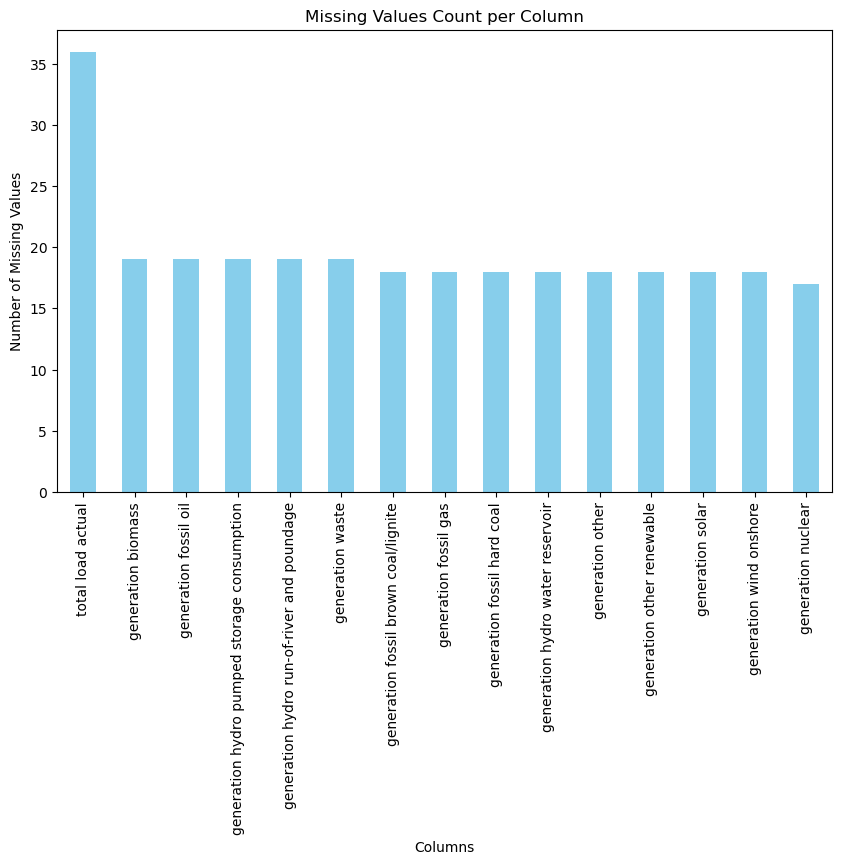

In [355]:
missing_count = df_energy.isna().sum()

# Plotting the missing values count
plt.figure(figsize=(10, 6))
missing_count[missing_count > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Missing Values Count per Column")
plt.ylabel("Number of Missing Values")
plt.xlabel("Columns")
plt.xticks(rotation=90)
plt.show()


In [356]:
print(df_energy['time'],df_energy['price actual'])

0       2014-12-31 23:00:00+00:00
1       2015-01-01 00:00:00+00:00
2       2015-01-01 01:00:00+00:00
3       2015-01-01 02:00:00+00:00
4       2015-01-01 03:00:00+00:00
                   ...           
35059   2018-12-31 18:00:00+00:00
35060   2018-12-31 19:00:00+00:00
35061   2018-12-31 20:00:00+00:00
35062   2018-12-31 21:00:00+00:00
35063   2018-12-31 22:00:00+00:00
Name: time, Length: 35064, dtype: datetime64[ns, UTC] 0        65.41
1        64.92
2        64.48
3        59.32
4        56.04
         ...  
35059    77.02
35060    76.16
35061    74.30
35062    69.89
35063    69.88
Name: price actual, Length: 35064, dtype: float64


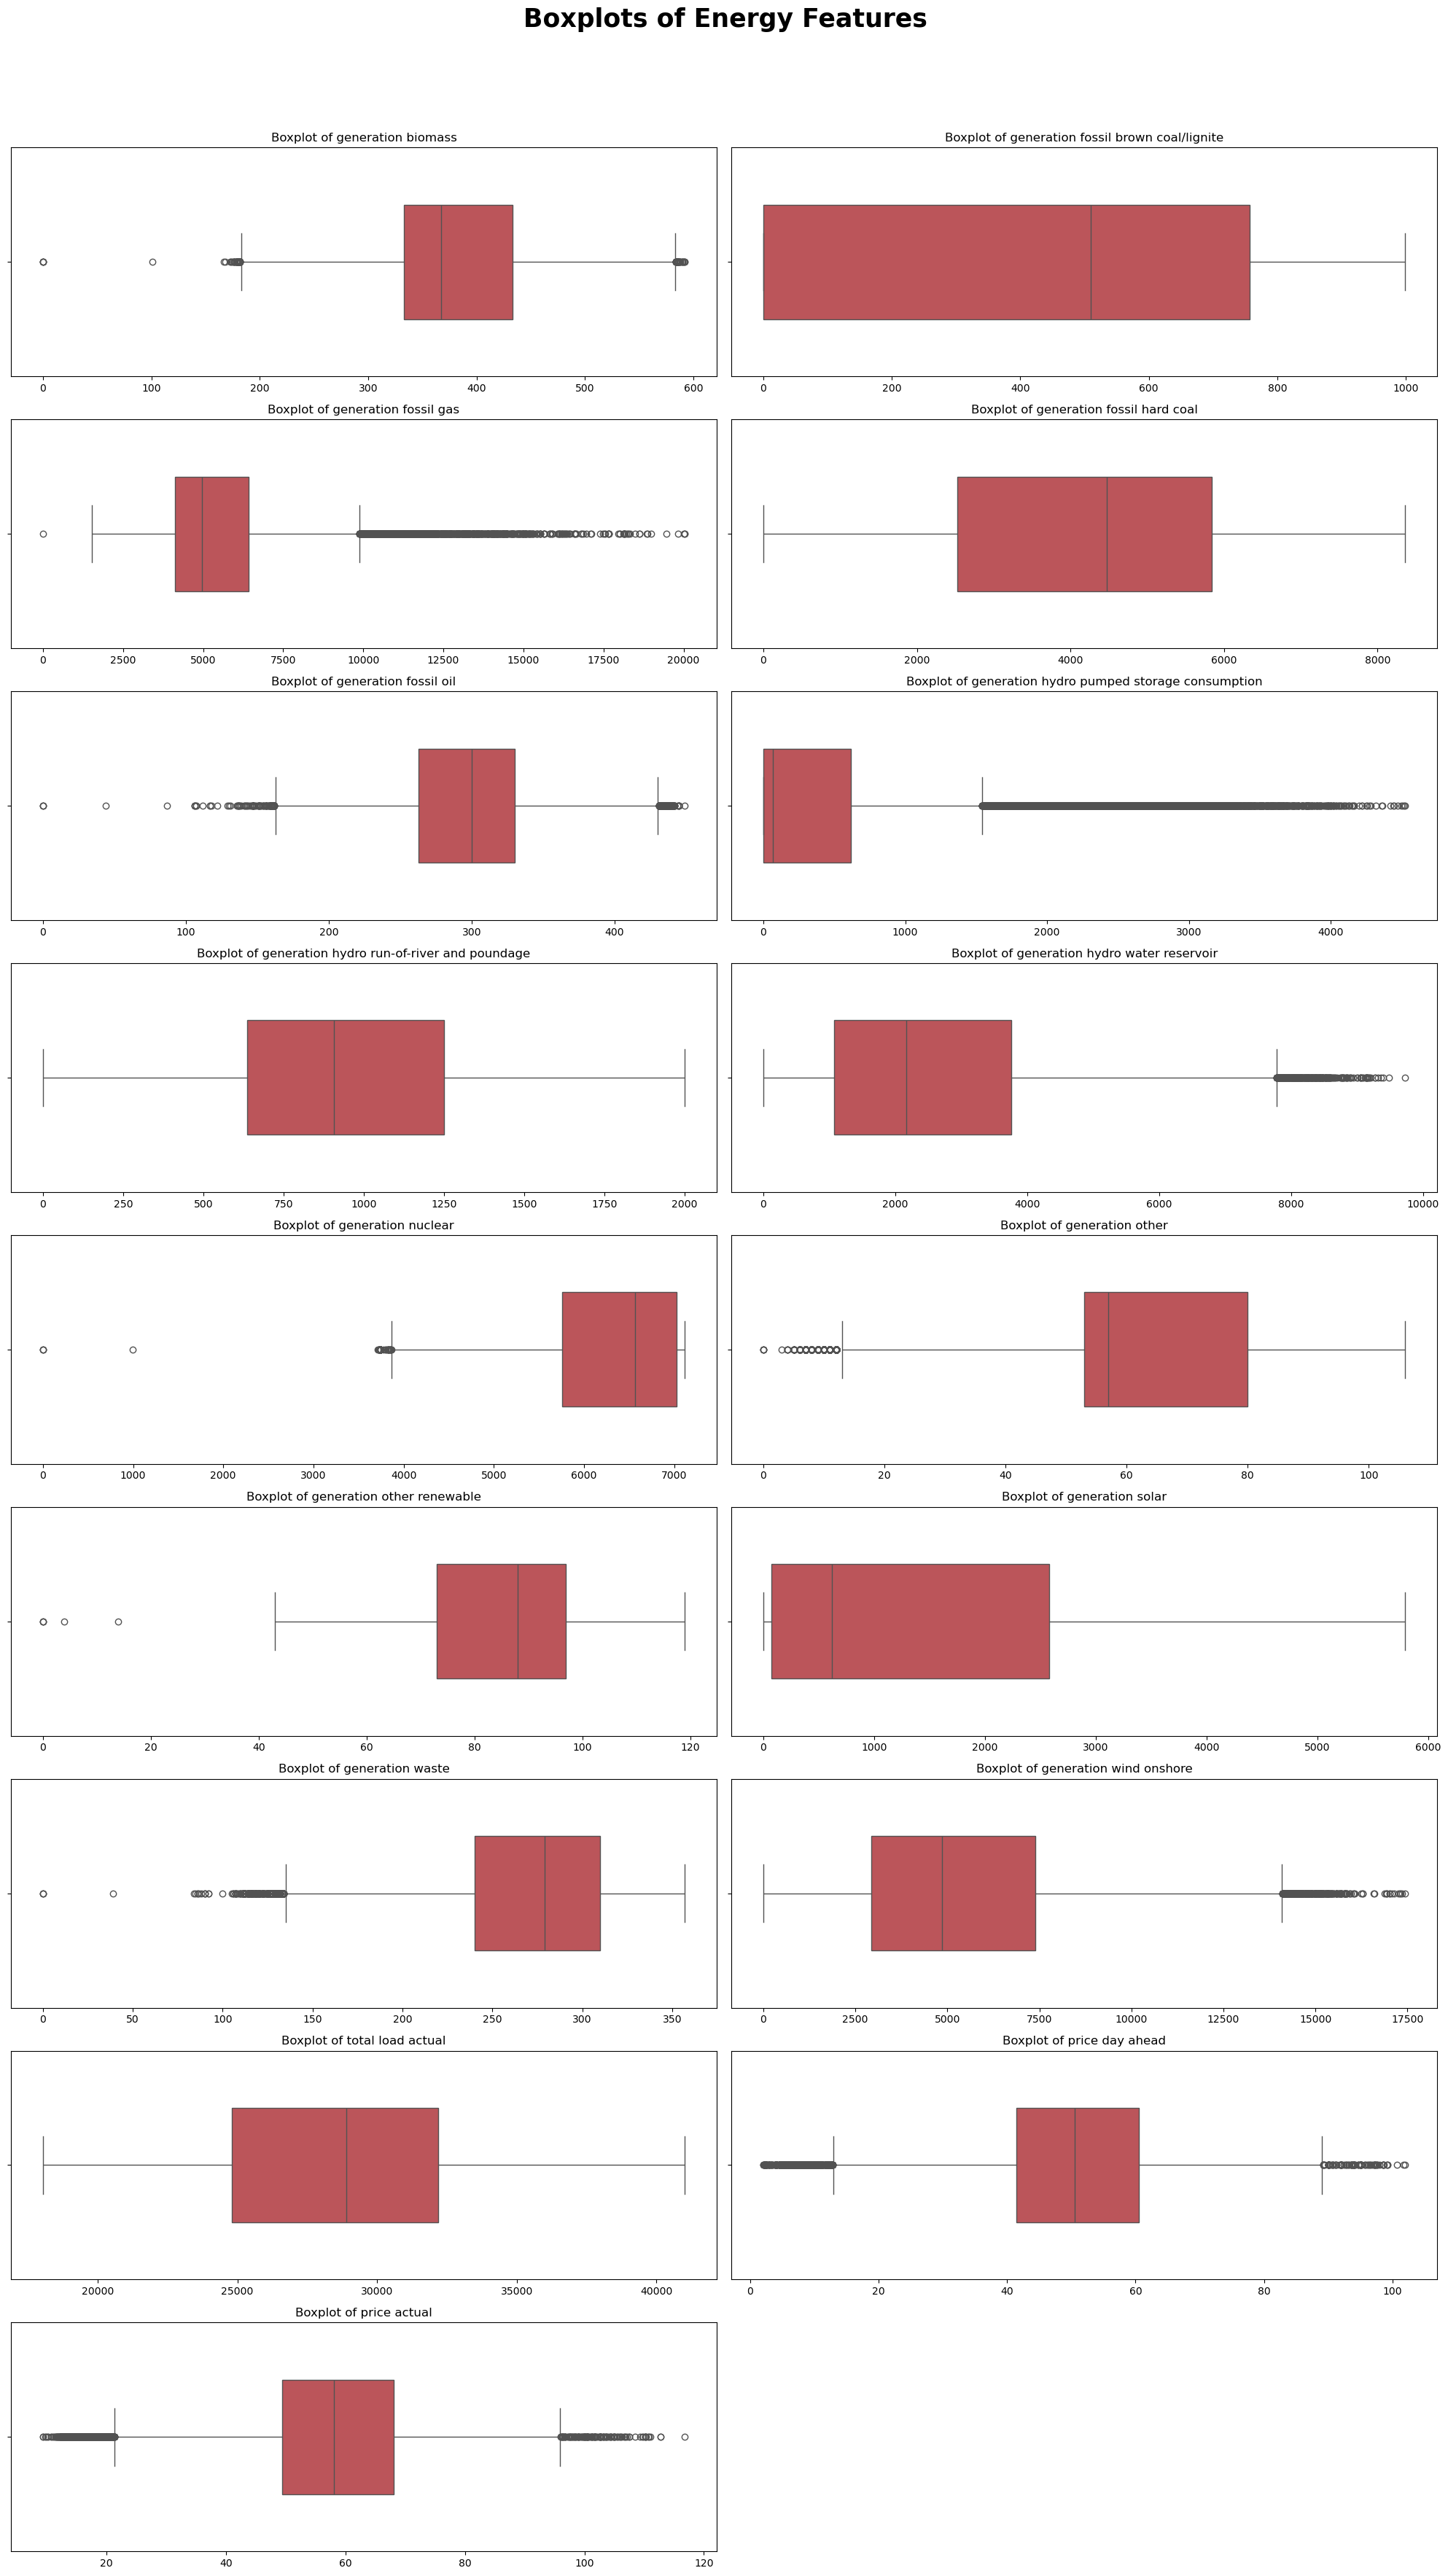

In [357]:
# Select numerical columns for plotting
columns = df_energy.select_dtypes(include=['float64', 'int64']).columns

# Calculate grid size (e.g., 2 columns per row)
ncols = 2
nrows = int(np.ceil(len(columns) / ncols))

# Create subplots
f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, nrows * 4))
f.suptitle('Boxplots of Energy Features', weight='bold', fontsize=25)

# Flatten axes array and iterate over columns
axes = axes.flatten()
for i, col in enumerate(columns):
    sns.boxplot(data=df_energy, x=col, ax=axes[i], color='#cc444b', width=0.5)
    axes[i].set_title(f"Boxplot of {col}", fontsize=12)
    axes[i].set_xlabel('')  # Remove x-axis label for cleanliness

# Remove unused subplots if columns are fewer than grid slots
for j in range(i + 1, len(axes)):
    f.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title
plt.show()

if we look closely, we are see some outliers, not alot of them though. we will fill them up with a 
FIGURE OUT

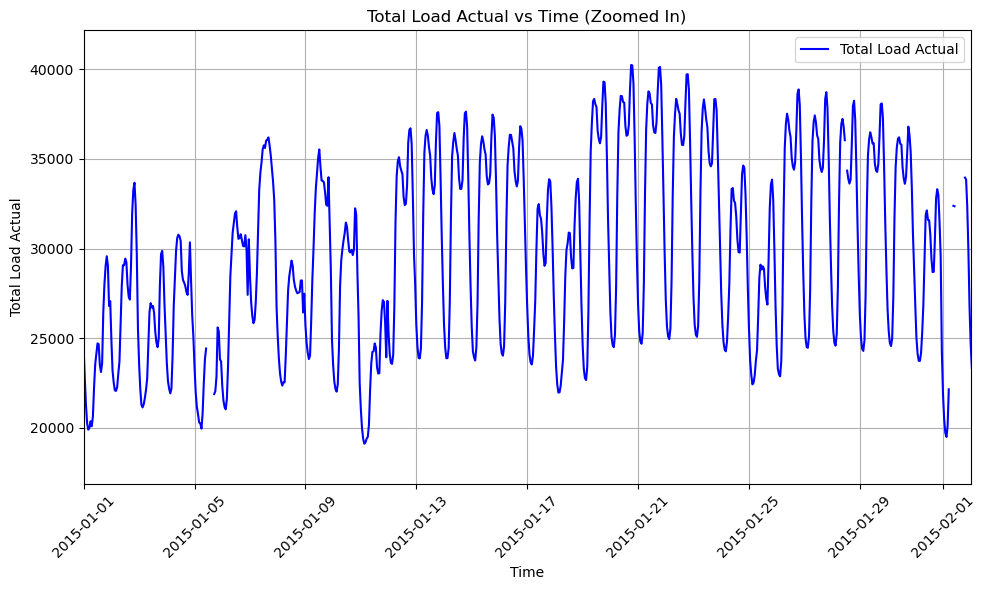

In [358]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy['time'], df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-02')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-02'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We can see that in the beginning of 2015-01-05 there is a missing value.
Time series data relies on the order and continuity of time-based observations. If you remove rows with missing data, you can break this continuity, leading to gaps in your time series, also , in more techinal approach, Many time series models (e.g., ARIMA, LSTM) require the data to be continuous and use previous observations to make predictions. Dropping rows can disturb this temporal relationship, leading to poor model performance.
so we will need to fill the missing values, as we can see in the plot we just plotted that the data of Load Actual is linear. so a good approach would be to use linear interplation in here.
2 more possible approachs that are common in time-series data is fill forward that will replaces NaN with the immediat next value, and backword fill thah replaces NaN with the immediate previous value.
The reason I am choosing linear interplation its becuase, as we can see there is a somekind of gap between night and day, which linear interploate will solve but the other methods can make a bigger gap and less smoother.

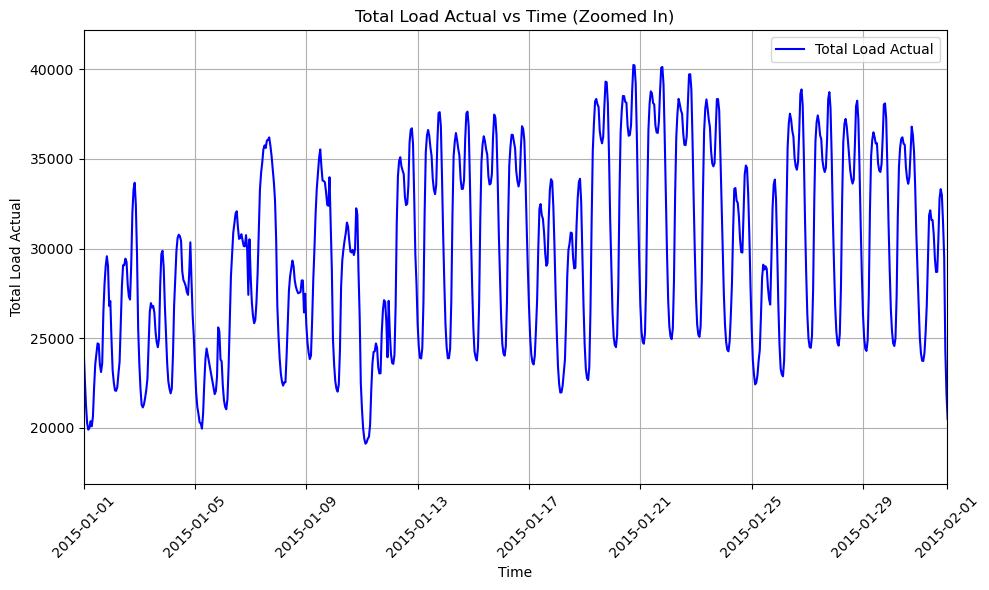

In [359]:

df_energy['total load actual'] = df_energy['total load actual'].interpolate(method='linear')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_energy['time'], df_energy['total load actual'], label='Total Load Actual', color='blue')

# Set x-axis limit to zoom into specific time range (e.g., from '2015-01-01' to '2015-02-01')
plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2015-02-01'))

plt.title('Total Load Actual vs Time (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Total Load Actual')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

we can see that missing value is filled and looked natural to function.

In [360]:
# Set the 'time' column as the index
df_energy.set_index('time', inplace=True)


/var/folders/nr/_1gf0z1x0pn1bn_02ky4wph40000gn/T/ipykernel_19344/3097740555.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


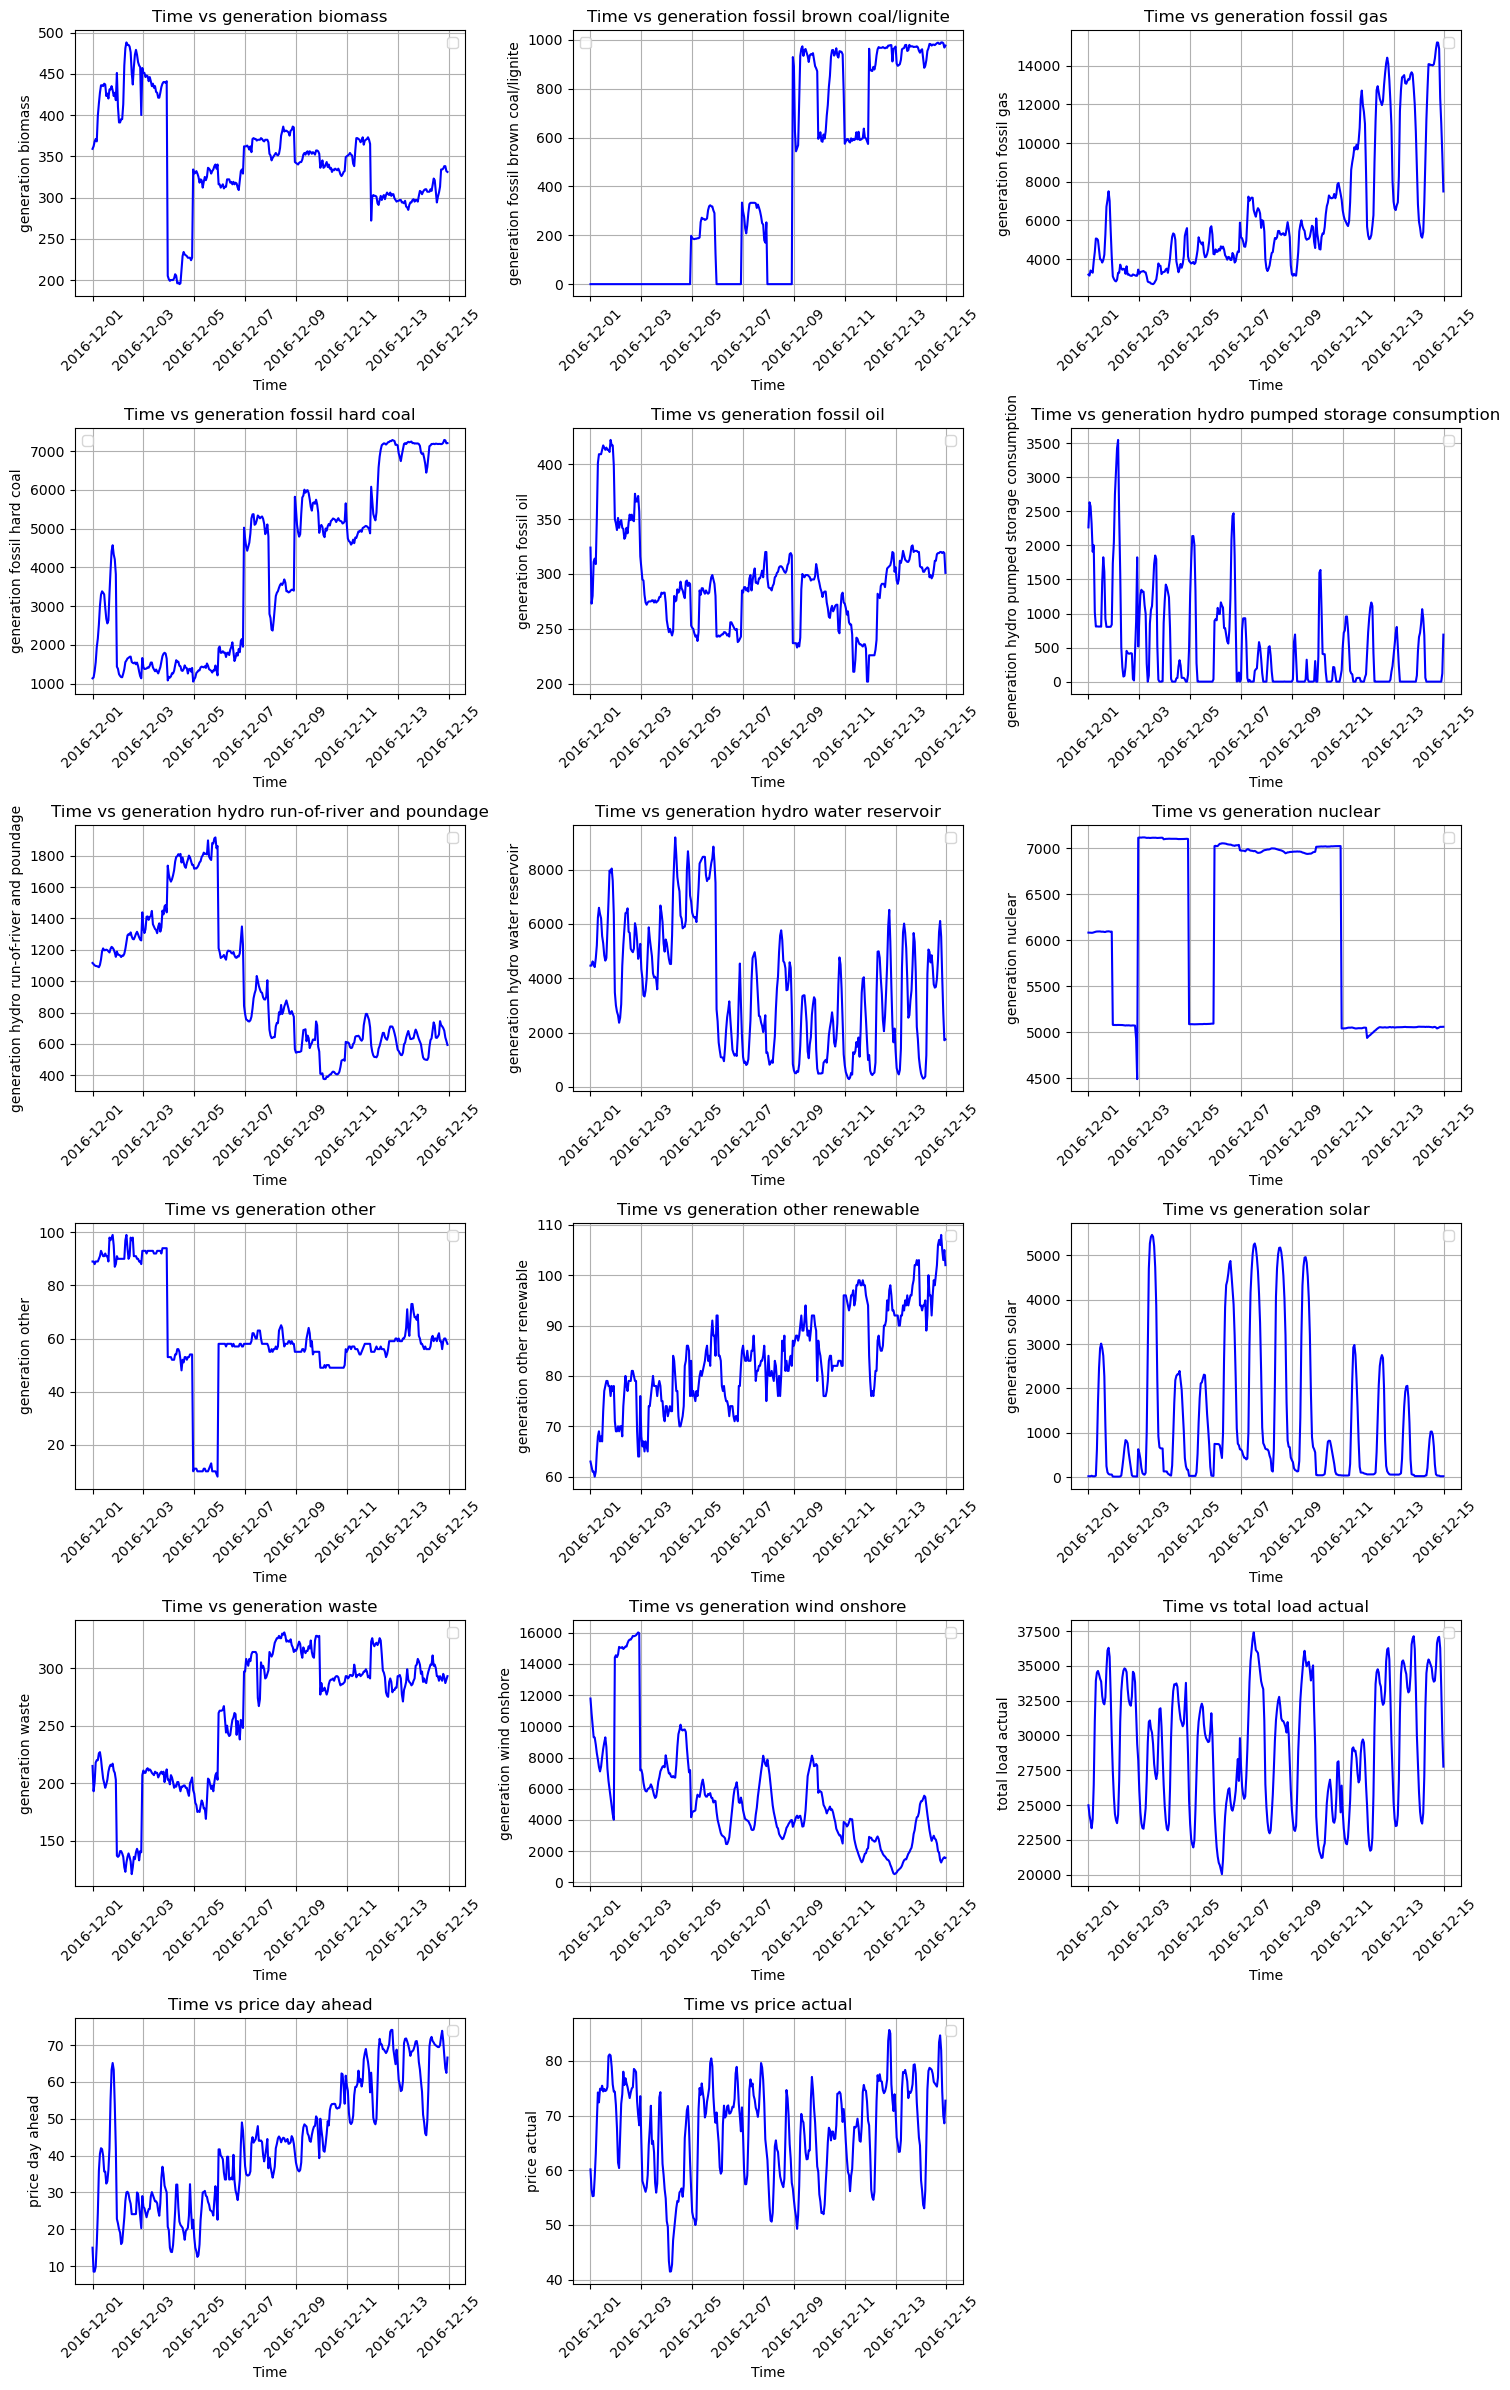

In [361]:
start_date = pd.Timestamp('2016-12-01 00:00:00', tz='UTC')
end_date = pd.Timestamp('2016-12-14 23:59:59', tz='UTC')

# Filter the DataFrame to include only the specific two-week period
df_two_weeks = df_energy.loc[start_date:end_date]
df_two_weeks.head()

# Get the number of columns to plot
columns = df_two_weeks.columns
n_columns = len(columns)

# Calculate the grid size
nrows = math.ceil(n_columns / 3)  # 3 columns per row
ncols = 3  # Fixed number of columns

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
axes = axes.flatten()  # Flatten to easily iterate over

for i, column in enumerate(columns):
    ax = axes[i]
    ax.plot(df_two_weeks.index, df_two_weeks[column] , color='blue')
    
    # Customize the plot
    ax.set_title(f"Time vs {column}")
    ax.set_xlabel("Time")
    ax.set_ylabel(f"{column}")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

# Remove unused subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [362]:
df_energy = df_energy.interpolate(method='linear')

In [363]:
null_percentage = df_energy.isnull().sum()/len(df_energy) * 100   
print(null_percentage)
# we can see there is no more missing values in the dataset

generation biomass                             0.0
generation fossil brown coal/lignite           0.0
generation fossil gas                          0.0
generation fossil hard coal                    0.0
generation fossil oil                          0.0
generation hydro pumped storage consumption    0.0
generation hydro run-of-river and poundage     0.0
generation hydro water reservoir               0.0
generation nuclear                             0.0
generation other                               0.0
generation other renewable                     0.0
generation solar                               0.0
generation waste                               0.0
generation wind onshore                        0.0
total load actual                              0.0
price day ahead                                0.0
price actual                                   0.0
dtype: float64


In [364]:
zeros_percentage = (df_energy == 0).sum()/len(df_energy) * 100
print(zeros_percentage)

generation biomass                              0.011408
generation fossil brown coal/lignite           30.013689
generation fossil gas                           0.002852
generation fossil hard coal                     0.008556
generation fossil oil                           0.008556
generation hydro pumped storage consumption    35.974219
generation hydro run-of-river and poundage      0.008556
generation hydro water reservoir                0.008556
generation nuclear                              0.008556
generation other                                0.011408
generation other renewable                      0.008556
generation solar                                0.008556
generation waste                                0.008556
generation wind onshore                         0.008556
total load actual                               0.000000
price day ahead                                 0.000000
price actual                                    0.000000
dtype: float64



## Data Cleaning Summary: df_energy Dataset
Generation fossil brown coal/lignite: This column represents electricity production from lignite, a low-grade coal. While it is an affordable and locally abundant energy source, it is among the least environmentally friendly due to high carbon emissions and inefficiency. Spain's significant investments in renewable energy sources, such as wind, solar, and hydropower, have reduced reliance on lignite. As a result, its use is often limited to periods when renewable generation and other cleaner options cannot meet demand, explaining the presence of zeros in 30% of the data.

Hydro pumped storage consumption: This column shows 35% zeros, which is expected. Pumped storage is utilized only during energy surplus periods to store energy, remaining inactive when supply and demand are balanced or when conditions do not require its operation.

The percentage of zeros in these columns is reasonable and does not indicate any inaccuracies in the data.

With these steps, the df_energy dataset is sufficiently cleaned for further analysis. Future work may include additional feature engineering and processing as needed.

Now, let's proceed to clean the weather dataset.

In [365]:
df_weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [366]:
df_weather['time'] = df_weather['dt_iso']
df_weather['time'] = pd.to_datetime(df_weather['time'],utc=True)
df_weather.index = df_weather['time']
print(df_weather['time'])
df_weather = df_weather.drop(['dt_iso'],axis=1)

time
2014-12-31 23:00:00+00:00   2014-12-31 23:00:00+00:00
2015-01-01 00:00:00+00:00   2015-01-01 00:00:00+00:00
2015-01-01 01:00:00+00:00   2015-01-01 01:00:00+00:00
2015-01-01 02:00:00+00:00   2015-01-01 02:00:00+00:00
2015-01-01 03:00:00+00:00   2015-01-01 03:00:00+00:00
                                       ...           
2018-12-31 18:00:00+00:00   2018-12-31 18:00:00+00:00
2018-12-31 19:00:00+00:00   2018-12-31 19:00:00+00:00
2018-12-31 20:00:00+00:00   2018-12-31 20:00:00+00:00
2018-12-31 21:00:00+00:00   2018-12-31 21:00:00+00:00
2018-12-31 22:00:00+00:00   2018-12-31 22:00:00+00:00
Name: time, Length: 178396, dtype: datetime64[ns, UTC]


In the data set we have 5 major cities in Spain that been sampled through 2014-2018, as we can see they have been sampled hourly, the same as the df_energy dataset which is excellent for us.
The length of the dataframes is 178396 which is 35064(the lenght of the df_energy dataset) * 5.

as we can see here -


In [367]:
print(len(df_energy.index.unique()))
print(len(df_weather.index.unique()))

35064
35064


As we know, in time-series data, duplicates are not allowed. Additionally, when extracting each city as its own feature, duplicates can cause issues. 

In this case, we observe that the total number of unique rows is 35,064, but for each city, we have more than 35,064 rows. This indicates that duplicates exist, and we need to remove them in order to proceed correctly.


In [368]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
for city, group in grouped:
    # Check for duplicates in the 'time' column
    duplicated_count = group['time'].duplicated().sum()
    print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
    print(f"Number of rows is {len(group)}")
    duplicated_rows = group[group['time'].duplicated(keep=False)]
    
    if not duplicated_rows.empty:
        print(f"City: {city}")
        print("Duplicated times:")
        print(duplicated_rows[['time']])
        print("\n")
    else:
        print(f"City: {city}, No duplicates\n")


City:  Barcelona, Number of duplicated rows based on 'time': 412
Number of rows is 35476
City:  Barcelona
Duplicated times:
                                               time
time                                               
2015-03-20 20:00:00+00:00 2015-03-20 20:00:00+00:00
2015-03-20 20:00:00+00:00 2015-03-20 20:00:00+00:00
2015-06-08 13:00:00+00:00 2015-06-08 13:00:00+00:00
2015-06-08 13:00:00+00:00 2015-06-08 13:00:00+00:00
2015-06-08 14:00:00+00:00 2015-06-08 14:00:00+00:00
...                                             ...
2018-12-06 05:00:00+00:00 2018-12-06 05:00:00+00:00
2018-12-14 01:00:00+00:00 2018-12-14 01:00:00+00:00
2018-12-14 01:00:00+00:00 2018-12-14 01:00:00+00:00
2018-12-26 05:00:00+00:00 2018-12-26 05:00:00+00:00
2018-12-26 05:00:00+00:00 2018-12-26 05:00:00+00:00

[805 rows x 1 columns]


City: Bilbao, Number of duplicated rows based on 'time': 887
Number of rows is 35951
City: Bilbao
Duplicated times:
                                               time
time  

In [369]:
# Group by 'time' and 'city_name' and filter for groups that have more than one row
duplicated_rows = df_weather[df_weather.duplicated(subset=['time', 'city_name'], keep=False)]

# Display the rows
print(duplicated_rows.head(10))


                          city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-01-06 03:00:00+00:00  Valencia  273.142   273.142   273.142       995   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 19:00:00+00:00  Valencia  289.610   288.650   290.930      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-06-15 20:00:00+00:00  Valencia  289.240   288.150   290.370      1018   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-18 17:00:00+00:00  Valencia  299.770   298.750   300.930      1013   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   
2015-07-31 21:00:00+00:00  Valencia  295.890   293.710   297.590      1009   

                           humidity  wind_speed  wind_deg  rain

As we can see, and after some manual(is it enough?) digging, The duplicated row mostly have the same values for the other columns.
so I will drop duplicates with keeping the first row(meaning that we will delete all the other rows that have the same 'time' and 'city_name')

In [370]:


df_weather = df_weather.drop_duplicates(subset=['time', 'city_name'], keep='last')  # Keep the last occurrence


In [371]:
grouped = df_weather.groupby('city_name')
# Iterate over each group (city_name) and its corresponding DataFrame
for city, group in grouped:
    # Check for duplicates in the 'time' column
    duplicated_count = group['time'].duplicated().sum()
    print(f"City: {city}, Number of duplicated rows based on 'time': {duplicated_count}")
    print(f"Number of rows is {len(group)}")
    duplicated_rows = group[group['time'].duplicated(keep=False)]
    
    if not duplicated_rows.empty:
        print(f"City: {city}")
        print("Duplicated times:")
        print(duplicated_rows[['time']])
        print("\n")
    else:
        print(f"City: {city}, No duplicates\n")

City:  Barcelona, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City:  Barcelona, No duplicates

City: Bilbao, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Bilbao, No duplicates

City: Madrid, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Madrid, No duplicates

City: Seville, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Seville, No duplicates

City: Valencia, Number of duplicated rows based on 'time': 0
Number of rows is 35064
City: Valencia, No duplicates



In [372]:
df_weather.describe()
# print(df_weather.isnull().sum()) there is no Null values in the dataset
zeros_percentage = (df_weather == 0).sum()/len(df_weather) * 100
print(zeros_percentage)

city_name               0.000000
temp                    0.000000
temp_min                0.000000
temp_max                0.000000
pressure                0.001141
humidity                0.035934
wind_speed             10.335957
wind_deg               13.888889
rain_1h                90.079854
rain_3h                98.942505
snow_3h                99.847707
clouds_all             46.777892
weather_id              0.000000
weather_main            0.000000
weather_description     0.000000
weather_icon            0.000000
time                    0.000000
dtype: float64


as we can see, the rain_3h(3 hours of raining) is a data that already contanied in the rain_1h(1 hour of raining), so, to remove the redundancy we will remove it.
also, we will take a look at the other columns and figure out if there is some more cleaning we need to do.

In [373]:
# df_weather = df_weather.drop(['rain_3h'],axis=1)
# df_weather.info()
# we see that there is some float64 and there is some int64, we will convert the int64 to float64
for col in df_weather.select_dtypes(include=['int64']).columns:
    df_weather[col] = df_weather[col].astype('float64')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   city_name            175320 non-null  object             
 1   temp                 175320 non-null  float64            
 2   temp_min             175320 non-null  float64            
 3   temp_max             175320 non-null  float64            
 4   pressure             175320 non-null  float64            
 5   humidity             175320 non-null  float64            
 6   wind_speed           175320 non-null  float64            
 7   wind_deg             175320 non-null  float64            
 8   rain_1h              175320 non-null  float64            
 9   rain_3h              175320 non-null  float64            
 10  snow_3h              175320 non-null  float64            
 11  clouds_all         

All the columns but weather_id,weather_meain,weather dscription and weather_icon and very self-explanibale. 
so now we will try to understand what information each of these columns give us and we need them all.
if we look at the data bases in the kaggle there is a brief explantion for each column.
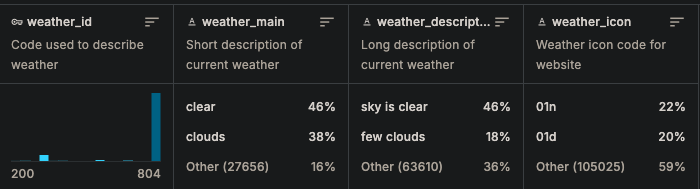


In [382]:

le = LabelEncoder()
# Encode categorical features
df_weather['weather_main'] = le.fit_transform(df_weather['weather_main'])
df_weather['weather_description'] = le.fit_transform(df_weather['weather_description'])

# Print the correlation between `weather_main` and `weather_id`
print(f"Correlation between weather_main and weather_id: {df_weather['weather_main'].corr(df_weather['weather_id'])}")

# as we can see the correlation is very high, we will drop the weather_id column, also the weather_icon column(not relevant for us) and weathers_description(too much specific can give us overfitting)
df_weather = df_weather.drop(['weather_id', 'weather_icon', 'weather_description'], axis=1)


Correlation between weather_main and weather_id: -0.8783431110073818
